# Transition path theory

TPT

https://www.nature.com/articles/srep17986

In [12]:
import numpy as np
import sktime

In [2]:
start = (7, 2)

In [3]:
sim = sktime.data.drunkards_walk(bar_location=(0, 0), home_location=(9, 9))

sim.add_barrier((5, 0), (5, 4))
sim.add_barrier((0, 9), (5, 8))
sim.add_barrier((9, 2), (7, 6))

walk = sim.walk(start=start, n_steps=250, seed=17)

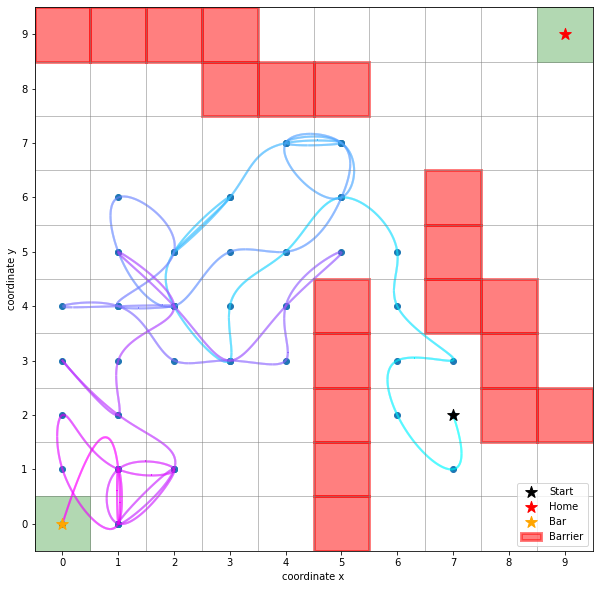

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(*start, marker='*', label='Start', c='black', s=150, zorder=5)
handles, labels = sim.plot_2d_map(ax)
sim.plot_path(ax, walk)
ax.legend(handles=handles, labels=labels);

In [5]:
flux = sim.msm.reactive_flux([sim.coordinate_to_state(start)], [sim.home_state, sim.bar_state])

In [6]:
#pcca = sim.msm.pcca(15)
#plt.matshow(pcca.coarse_grained_transition_matrix)

In [7]:
paths, capacities = flux.pathways()

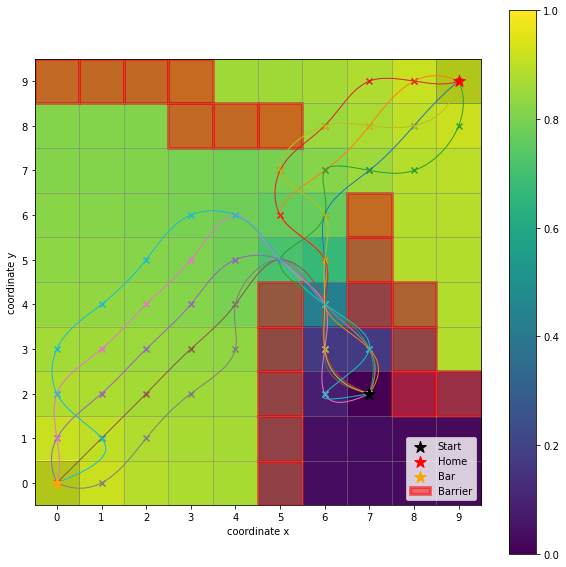

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(*start, marker='*', label='Start', c='black', s=150, zorder=5)
handles, labels = sim.plot_2d_map(ax)

for capacity, path in zip((capacities / np.array(capacities).sum())[:10], paths[:10]):
    path = np.array([sim.state_to_coordinate(state) for state in path])
    sim.plot_path(ax, path, lw=1., intermediates=False, color_lerp=False)
    ax.scatter(*path.T, marker='x')

Q = flux.forward_committor.reshape(sim.grid_size)
cb = ax.imshow(Q, interpolation='nearest', origin='lower')
fig.colorbar(cb, ax=ax)

ax.legend(handles=handles, labels=labels);

In [14]:
gross_flux = flux.gross_flux.m

In [15]:
gross_flux.shape

(100, 100)

In [21]:
x = np.arange(-1/2, sim.grid_size[0]-1 + 1/2, 1/2.)
y = np.arange(-1/2, sim.grid_size[1]-1 + 1/2, 1/2.)
X, Y = np.meshgrid(x, y, indexing='ij')
U = np.zeros_like(X)
V = np.zeros_like(X)

In [23]:
F = flux.net_flux.m

In [24]:
for i in range(sim.grid_size[0]):
    for j in range(sim.grid_size[1]):
        i_grid = 2*i + 1
        j_grid = 2*j + 1
        coord = (i, j)
        state = sim.coordinate_to_state(coord)
        
        for offset_i in [-1, 0, 1]:
            for offset_j in [-1, 0, 1]:
                neighbor_coord = (i + offset_i, j + offset_j)
                if sim.is_valid_coordinate(neighbor_coord):
                    neighbor_state = sim.coordinate_to_state(neighbor_coord)
                    neighbor_F = F[state, neighbor_state]
                    U[i_grid + offset_i, j_grid + offset_j] += offset_i * neighbor_F
                    V[i_grid + offset_i, j_grid + offset_j] += offset_j * neighbor_F

(-0.5, 9.5)

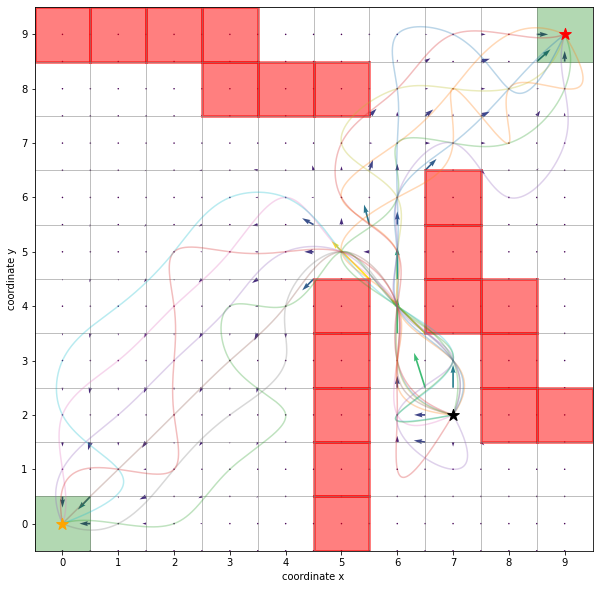

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(*start, marker='*', label='Start', c='black', s=150, zorder=5)

sim.plot_2d_map(ax)

for capacity, path in zip(capacities[:15], paths[:15]):
    path = np.array([sim.state_to_coordinate(state) for state in path])
    sim.plot_path(ax, path, intermediates=False, color_lerp=False, alpha=.3)

C = np.linalg.norm(np.vstack((U.flatten(),V.flatten())),axis=0)
ax.quiver(X, Y, U, V, C, scale=8*flux.total_flux.m)
ax.set_xlim([-.5, sim.grid_size[0]-.5])
ax.set_ylim([-.5, sim.grid_size[1]-.5])